# Boston Urban Equity — Cross-Project Synthesis
**Projects:** Accessibility & Inequality Index (P1) · Bus Service Failure Risk (P2) · Commercial Viability Index (P3)

This notebook works through six explicit research questions using the processed outputs from all three projects. Each section answers one question, building toward a tract-level Compounding Burden Index and a set of policy recommendations grounded in the data.

The notebook is written to run on your machine. All file paths are defined in Section 0. Run cells top to bottom — each section depends on the join built in Section 1.


## 0. Setup

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy import stats
from pathlib import Path

# ── Paths ─────────────────────────────────────────────────────────────────
P1_GPKG  = Path("/Users/administrator/Documents/project 1/data_processed/svi_access_full.gpkg")
P2_FEAT  = Path("/Users/administrator/Documents/project 2/parquets/bus_service_failure_features_2024.parquet")
P2_MODEL = Path("/Users/administrator/Documents/project 2/parquets/model_table_thin_2024.parquet")
P3_GPKG  = Path("/Users/administrator/Documents/project 3/data/processed/cvi_scored.gpkg")
STOPS_TXT = Path("/Users/administrator/Documents/project 2/MBTA_GTFS/stops.txt")

# ── Style ─────────────────────────────────────────────────────────────────
DARK = "#0C0C0F"; SURF = "#16161A"; BORD = "#2A2A32"
TEXT = "#E8E4DC"; MUTED = "#7A7570"
C1 = "#2DB5A3"; C2 = "#4A7AB5"; C3 = "#D4854A"; C4 = "#C94040"; GOLD = "#C9A84C"
QCOLS = [C4, "#E07050", GOLD, "#6AAA8A", C1]  # Q1 worst → Q5 best

plt.rcParams.update({
    "figure.facecolor": DARK, "axes.facecolor": SURF,
    "axes.edgecolor": BORD,   "text.color": TEXT,
    "axes.labelcolor": MUTED, "xtick.color": MUTED,
    "ytick.color": MUTED,     "grid.color": BORD,
    "grid.alpha": 0.4,
})

def annotate_bars(ax, bars, fmt="{:.1f}", offset=0.3, horizontal=False):
    """Add value labels to bar charts."""
    for bar in bars:
        if horizontal:
            val = bar.get_width()
            ax.text(val + offset, bar.get_y() + bar.get_height()/2,
                    fmt.format(val), va="center", color=TEXT, fontsize=8)
        else:
            val = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2, val + offset,
                    fmt.format(val), ha="center", color=TEXT, fontsize=8)

print("OK")


OK


## 1. Load and join all three datasets

Three independent datasets, each at a different unit of analysis:
- **P1** — 195 Boston census tracts with SVI scores and 4 service access risk scores
- **P2** — 27M bus stop events; aggregated here to per-stop failure rates, then spatially joined to tracts
- **P3** — 205 census tracts with CVI, gap score, income, POI density

The join key is the census tract FIPS/GEOID code. P2 bus stops are assigned to tracts via spatial join, then aggregated.


In [2]:
# ── P1 ────────────────────────────────────────────────────────────────────
P1_KEEP = [
    "FIPS", "RPL_THEMES",
    "E_TOTPOP", "EP_POV150", "EP_MINRTY", "EP_AGE65", "EP_LIMENG", "EP_NOVEH",
    "health_access_risk", "shop_access_risk", "park_access_risk", "transit_access_risk",
    "accessibility_index", "access_inequality_index", "geometry"
]
p1 = gpd.read_file(P1_GPKG, layer="tracts_access_risk")[P1_KEEP].copy()
p1["FIPS"] = p1["FIPS"].astype(str).str.zfill(11)

print(f"P1: {p1.shape[0]} tracts | CRS: {p1.crs}")
print(f"SVI range: {p1['RPL_THEMES'].min():.3f} – {p1['RPL_THEMES'].max():.3f}")


P1: 195 tracts | CRS: EPSG:26986
SVI range: 0.000 – 0.996


In [3]:
# ── P3 ────────────────────────────────────────────────────────────────────
p3 = gpd.read_file(P3_GPKG)
p3["FIPS"] = p3["GEOID"].astype(str).str.zfill(11)

P3_KEEP = ["FIPS", "total_population", "median_hh_income", "total_stops",
           "has_rapid_transit", "total_pois", "pillar1_transit",
           "pillar2_demographics", "pillar3_poi_density",
           "cvi_score", "demand_score", "supply_score", "gap_score"]
p3_thin = p3[P3_KEEP].copy()

print(f"P3: {p3.shape[0]} tracts")
print(f"CVI range:     {p3['cvi_score'].min():.1f} – {p3['cvi_score'].max():.1f}")
print(f"Gap score range: {p3['gap_score'].min():.1f} – {p3['gap_score'].max():.1f}")
print(f"Income range:  ${p3['median_hh_income'].min():,.0f} – ${p3['median_hh_income'].max():,.0f}")


P3: 205 tracts
CVI range:     0.0 – 100.0
Gap score range: -100.0 – 64.4
Income range:  $18,125 – $245,000


In [4]:
# ── P1 + P3 join ──────────────────────────────────────────────────────────
df = p1.merge(p3_thin, on="FIPS", how="inner")
print(f"P1 + P3 joined: {df.shape[0]} tracts (inner join — tracts present in both)")
print(f"Lost from P1: {p1.shape[0] - df.shape[0]}  |  Lost from P3: {p3.shape[0] - df.shape[0]}")


P1 + P3 joined: 195 tracts (inner join — tracts present in both)
Lost from P1: 0  |  Lost from P3: 10


In [5]:
# ── P2: aggregate stop events → per-stop failure rate ─────────────────────
feat = pd.read_parquet(P2_FEAT)
print(f"P2 raw events: {len(feat):,}")
print(f"Overall failure rate: {feat['service_failure'].mean()*100:.1f}%")

stop_risk = (
    feat.groupby("stop_id", observed=True)
    .agg(failure_rate=("service_failure", "mean"),
         n_events=("service_failure", "size"))
    .reset_index()
)
stop_risk = stop_risk[stop_risk["n_events"] >= 50].copy()
print(f"Stops with ≥50 events: {len(stop_risk):,}")
print(f"Stop-level failure rate: mean={stop_risk['failure_rate'].mean():.3f}, "
      f"max={stop_risk['failure_rate'].max():.3f}")
del feat


P2 raw events: 27,049,203
Overall failure rate: 9.0%
Stops with ≥50 events: 1,156
Stop-level failure rate: mean=0.112, max=0.640


In [6]:
# ── Attach stop coordinates and spatial join to tracts ────────────────────
stops_coords = pd.read_csv(STOPS_TXT)[["stop_id","stop_lat","stop_lon"]]
stops_coords["stop_id"] = stops_coords["stop_id"].astype(str)
stop_risk["stop_id"]    = stop_risk["stop_id"].astype(str)

stop_gdf = (
    stop_risk.merge(stops_coords, on="stop_id", how="left")
    .dropna(subset=["stop_lat","stop_lon"])
    .pipe(lambda d: gpd.GeoDataFrame(
        d, crs="EPSG:4326",
        geometry=gpd.points_from_xy(d["stop_lon"], d["stop_lat"])
    ))
)

# Spatial join: stop → tract
stops_in_tracts = gpd.sjoin(
    stop_gdf[["stop_id","failure_rate","n_events","geometry"]],
    df[["FIPS","geometry"]].to_crs("EPSG:4326"),
    how="left", predicate="within"
)

tract_bus = (
    stops_in_tracts.dropna(subset=["FIPS"])
    .groupby("FIPS", as_index=False)
    .agg(bus_failure_rate=("failure_rate","mean"),
         bus_stop_count=("stop_id","nunique"),
         bus_total_events=("n_events","sum"))
)

df = df.merge(tract_bus, on="FIPS", how="left")
df["bus_stop_count"]   = df["bus_stop_count"].fillna(0).astype(int)
df["bus_total_events"] = df["bus_total_events"].fillna(0).astype(int)

# Centroid coordinates for spatial plots
df["cx"] = df.geometry.to_crs("EPSG:4326").centroid.x
df["cy"] = df.geometry.to_crs("EPSG:4326").centroid.y

print(f"Final dataset: {df.shape[0]} tracts × {df.shape[1]} columns")
print(f"Tracts with bus failure data: {df['bus_failure_rate'].notna().sum()}")
print(f"Tracts with zero bus stops:   {(df['bus_stop_count']==0).sum()}")


Final dataset: 195 tracts × 32 columns
Tracts with bus failure data: 143
Tracts with zero bus stops:   52


---
## Q1: Does social vulnerability predict worse service access?

**Using P1 alone.** Before crossing projects, we need to know how strongly SVI (RPL_THEMES) relates to each of the four access risk scores computed in Project 1. This sets the baseline for the cross-project questions.

The P1 notebook already produced correlations and High/Low SVI comparisons. Here we add the income quintile breakdown — a cleaner read than the binary SVI split because it shows the gradient, not just a median cut.


In [7]:
# ── Income quintile profiles across all service access risks ──────────────
df["income_q"] = pd.qcut(df["median_hh_income"], 5,
    labels=["Q1 poorest","Q2","Q3","Q4","Q5 richest"])

ACCESS_COLS = ["health_access_risk","shop_access_risk","park_access_risk","transit_access_risk"]
ACCESS_LABELS = ["Healthcare","Food shops","Parks","Transit"]

q_access = df.groupby("income_q", observed=True)[ACCESS_COLS].mean()
print("Mean access risk by income quintile (higher = worse access):")
print(q_access.round(3).to_string())


Mean access risk by income quintile (higher = worse access):
            health_access_risk  shop_access_risk  park_access_risk  transit_access_risk
income_q                                                                               
Q1 poorest               0.241             0.265             0.109                0.206
Q2                       0.251             0.245             0.116                0.192
Q3                       0.294             0.234             0.155                0.238
Q4                       0.236             0.225             0.121                0.262
Q5 richest               0.241             0.212             0.190                0.238


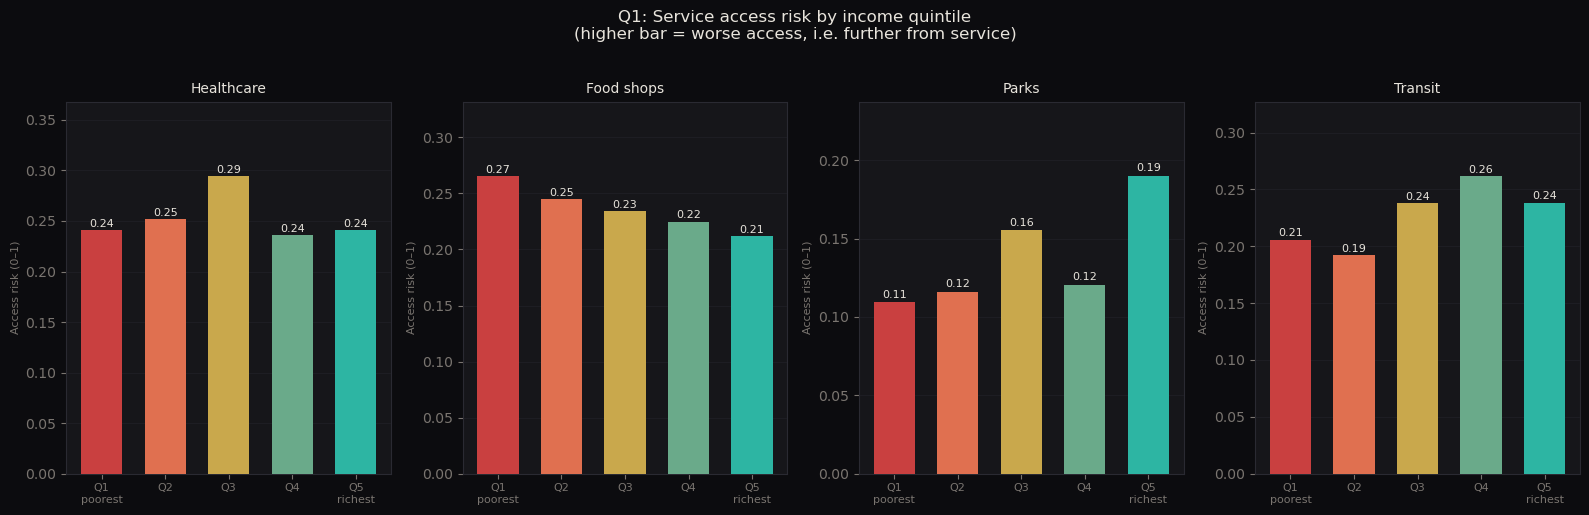

In [8]:
fig, axes = plt.subplots(1, 4, figsize=(16, 5))
fig.suptitle("Q1: Service access risk by income quintile\n"
             "(higher bar = worse access, i.e. further from service)",
             color=TEXT, fontsize=12, y=1.02)

q_labels = ["Q1\npoorest","Q2","Q3","Q4","Q5\nrichest"]
service_colors = [C1, C3, C2, C4]

for ax, col, label, color in zip(axes, ACCESS_COLS, ACCESS_LABELS, service_colors):
    vals = q_access[col].values
    bars = ax.bar(range(5), vals, color=QCOLS, width=0.65, zorder=3)
    ax.set_xticks(range(5))
    ax.set_xticklabels(q_labels, fontsize=8)
    ax.set_title(label, color=TEXT, fontsize=10)
    ax.set_ylabel("Access risk (0–1)", color=MUTED, fontsize=8)
    ax.set_ylim(0, max(vals)*1.25)
    ax.grid(axis="y", alpha=0.4)
    annotate_bars(ax, bars, fmt="{:.2f}", offset=0.003)

plt.tight_layout()
plt.show()


In [9]:
# ── Correlations with SVI ─────────────────────────────────────────────────
corr_svi = df[ACCESS_COLS + ["RPL_THEMES"]].corr()["RPL_THEMES"].drop("RPL_THEMES")
print("Pearson r with SVI (RPL_THEMES):")
for col, label in zip(ACCESS_COLS, ACCESS_LABELS):
    r, p = stats.pearsonr(df[col].dropna(), df.loc[df[col].notna(),"RPL_THEMES"])
    sig = "***" if p<0.001 else ("**" if p<0.01 else ("*" if p<0.05 else "n.s."))
    print(f"  {label:<14} r={r:+.3f}  p={p:.4f}  {sig}")

print()
print("Key finding: food shop access has the strongest positive association with")
print("vulnerability (r≈+0.25). Park and transit show weak negative correlations —")
print("these services are more evenly distributed across income levels.")


Pearson r with SVI (RPL_THEMES):
  Healthcare     r=+0.123  p=0.0876  n.s.
  Food shops     r=+0.245  p=0.0006  ***
  Parks          r=-0.102  p=0.1542  n.s.
  Transit        r=-0.119  p=0.0961  n.s.

Key finding: food shop access has the strongest positive association with
vulnerability (r≈+0.25). Park and transit show weak negative correlations —
these services are more evenly distributed across income levels.


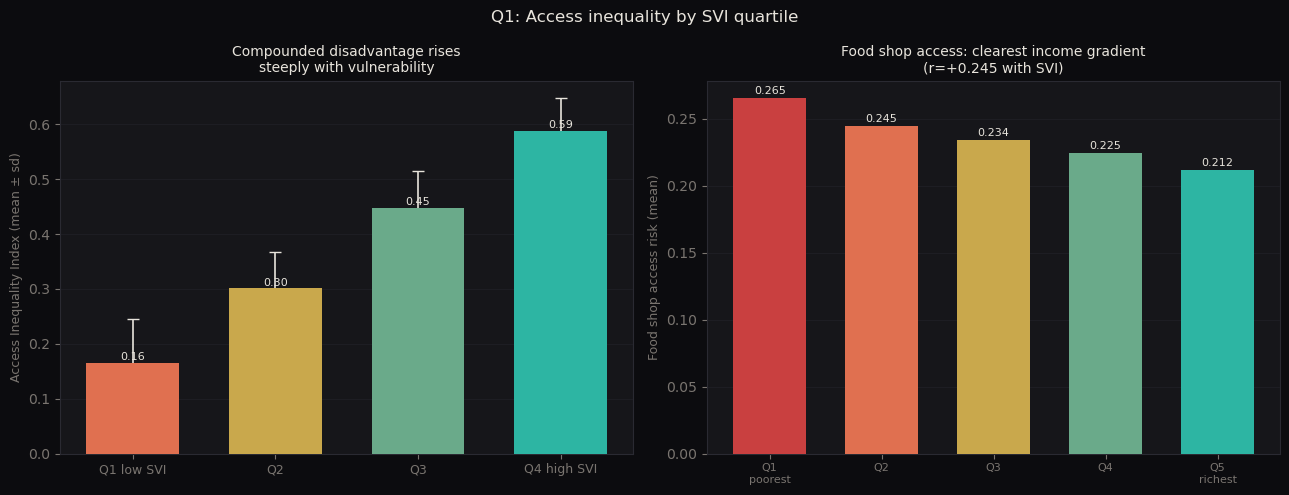


Answer to Q1:
Yes, but selectively. Food shop and healthcare access are meaningfully worse
in high-vulnerability tracts. Park and transit access show no clear gradient —
these services are distributed more evenly across the city.


In [10]:
# ── SVI quartile breakdown of access inequality index ────────────────────
df["svi_q"] = pd.qcut(df["RPL_THEMES"], 4,
    labels=["Q1 low SVI","Q2","Q3","Q4 high SVI"])

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("Q1: Access inequality by SVI quartile", color=TEXT, fontsize=12)

# Left: access inequality index by SVI quartile
ax = axes[0]
means = df.groupby("svi_q", observed=True)["access_inequality_index"].mean()
stds  = df.groupby("svi_q", observed=True)["access_inequality_index"].std()
bars  = ax.bar(range(4), means, color=QCOLS[1:], width=0.65, zorder=3)
ax.errorbar(range(4), means, yerr=stds, fmt="none", color=TEXT, capsize=4, lw=1.2)
ax.set_xticks(range(4))
ax.set_xticklabels(["Q1 low SVI","Q2","Q3","Q4 high SVI"], fontsize=9)
ax.set_ylabel("Access Inequality Index (mean ± sd)", color=MUTED, fontsize=9)
ax.set_title("Compounded disadvantage rises\nsteeply with vulnerability", color=TEXT, fontsize=10)
ax.grid(axis="y", alpha=0.4)
annotate_bars(ax, bars, fmt="{:.2f}", offset=0.005)

# Right: shop access risk by income quintile (strongest signal)
ax = axes[1]
shop_by_q = df.groupby("income_q", observed=True)["shop_access_risk"].mean()
bars = ax.bar(range(5), shop_by_q, color=QCOLS, width=0.65, zorder=3)
ax.set_xticks(range(5))
ax.set_xticklabels(q_labels, fontsize=8)
ax.set_ylabel("Food shop access risk (mean)", color=MUTED, fontsize=9)
ax.set_title("Food shop access: clearest income gradient\n(r=+0.245 with SVI)", color=TEXT, fontsize=10)
ax.grid(axis="y", alpha=0.4)
annotate_bars(ax, bars, fmt="{:.3f}", offset=0.003)

plt.tight_layout()
plt.show()

print("\nAnswer to Q1:")
print("Yes, but selectively. Food shop and healthcare access are meaningfully worse")
print("in high-vulnerability tracts. Park and transit access show no clear gradient —")
print("these services are distributed more evenly across the city.")


---
## Q2: Do vulnerable tracts have more unreliable transit?

**Crossing P1 (SVI) and P2 (bus failure rate).** This is the structural question from Idea 5. If vulnerable communities are not only further from services but also served by less reliable transit, the burden compounds in a specific way — it is not just about physical distance, it is about whether the service works when you need it.

Note: 52 of 195 tracts have zero bus stops in the spatial join. For those, bus_failure_rate is NaN. We analyse only tracts with stops (n=143), and separately examine the zero-stop tracts.


In [11]:
df_bus = df.dropna(subset=["bus_failure_rate"]).copy()
print(f"Tracts with bus data: {len(df_bus)}")
print(f"Tracts with zero stops (excluded from reliability analysis): {(df['bus_stop_count']==0).sum()}")
print()

r_svi, p_svi = stats.pearsonr(df_bus["RPL_THEMES"], df_bus["bus_failure_rate"])
r_acc, p_acc = stats.pearsonr(df_bus["access_inequality_index"], df_bus["bus_failure_rate"])
r_inc, p_inc = stats.pearsonr(df_bus["median_hh_income"], df_bus["bus_failure_rate"])

print("Correlations with bus failure rate:")
print(f"  SVI (RPL_THEMES):          r={r_svi:+.3f}  p={p_svi:.4f}")
print(f"  Access inequality index:   r={r_acc:+.3f}  p={p_acc:.4f}")
print(f"  Median household income:   r={r_inc:+.3f}  p={p_inc:.4f}")
print()
print("All correlations are weak and not significant at p<0.05.")
print("Bus failure risk is not straightforwardly explained by neighbourhood income")
print("or vulnerability. Something else is driving it — likely route-level and")
print("operational factors, which SHAP confirmed (hour and headway dominate).")


Tracts with bus data: 143
Tracts with zero stops (excluded from reliability analysis): 52

Correlations with bus failure rate:
  SVI (RPL_THEMES):          r=+0.139  p=0.0973
  Access inequality index:   r=+0.136  p=0.1056
  Median household income:   r=-0.035  p=0.6756

All correlations are weak and not significant at p<0.05.
Bus failure risk is not straightforwardly explained by neighbourhood income
or vulnerability. Something else is driving it — likely route-level and
operational factors, which SHAP confirmed (hour and headway dominate).


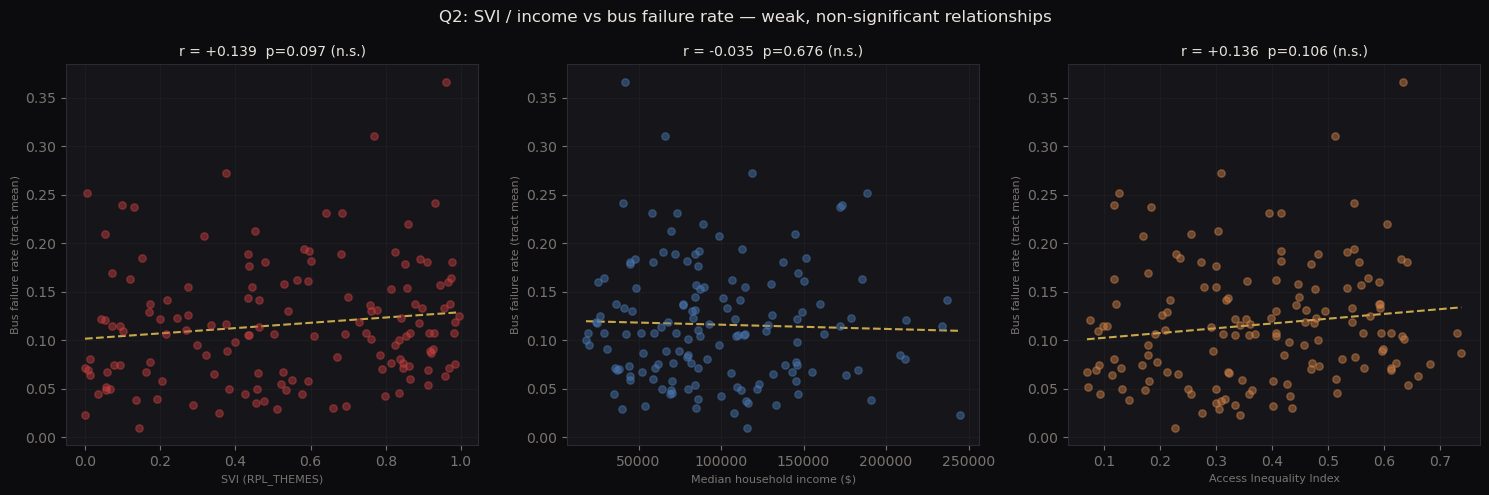

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle("Q2: SVI / income vs bus failure rate — weak, non-significant relationships",
             color=TEXT, fontsize=12)

pairs = [
    ("RPL_THEMES", "SVI (RPL_THEMES)", C4),
    ("median_hh_income", "Median household income ($)", C2),
    ("access_inequality_index", "Access Inequality Index", C3),
]
for ax, (xcol, xlabel, color) in zip(axes, pairs):
    x = df_bus[xcol]
    y = df_bus["bus_failure_rate"]
    ax.scatter(x, y, color=color, alpha=0.45, s=28, zorder=3)
    m, b, r, p, _ = stats.linregress(x.fillna(0), y)
    xl = np.linspace(x.min(), x.max(), 100)
    ax.plot(xl, m*xl+b, color=GOLD, lw=1.5, ls="--")
    sig = "p<0.05" if p < 0.05 else f"p={p:.3f} (n.s.)"
    ax.set_title(f"r = {r:+.3f}  {sig}", color=TEXT, fontsize=10)
    ax.set_xlabel(xlabel, color=MUTED, fontsize=8)
    ax.set_ylabel("Bus failure rate (tract mean)", color=MUTED, fontsize=8)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [13]:
# ── Zero-stop tracts: the harder inequality ───────────────────────────────
# No reliability data because there is no service at all
zero_stop = df[df["bus_stop_count"] == 0].copy()
has_stop  = df[df["bus_stop_count"] >  0].copy()

print("Comparing tracts WITH and WITHOUT bus stops:")
print(f"{'':30s}  {'Zero stops':>12}  {'Has stops':>12}")
print("-" * 58)
for col, label in [("RPL_THEMES","Avg SVI"),
                   ("median_hh_income","Avg income ($)"),
                   ("EP_POV150","Poverty rate (%)"),
                   ("EP_MINRTY","Minority pct (%)"),
                   ("E_TOTPOP","Avg population")]:
    z = zero_stop[col].mean()
    h = has_stop[col].mean()
    print(f"{label:30s}  {z:>12,.1f}  {h:>12,.1f}")

t_stat, p_val = stats.ttest_ind(zero_stop["RPL_THEMES"], has_stop["RPL_THEMES"])
print(f"\nt-test SVI zero-stop vs has-stop: t={t_stat:.3f}, p={p_val:.4f}")
print()
print("Answer to Q2:")
print("Bus failure RATE does not clearly track vulnerability — operational factors")
print("dominate. But the more fundamental inequality is ACCESS: 52 tracts with")
print(f"{zero_stop['E_TOTPOP'].sum():,.0f} residents have zero bus stops within their boundary.")
print("Vulnerability is not mainly about unreliable buses. It is about no bus at all.")


Comparing tracts WITH and WITHOUT bus stops:
                                  Zero stops     Has stops
----------------------------------------------------------
Avg SVI                                  0.5           0.5
Avg income ($)                      93,250.8      96,937.1
Poverty rate (%)                        24.2          25.0
Minority pct (%)                        51.1          52.4
Avg population                       2,869.3       3,586.8

t-test SVI zero-stop vs has-stop: t=0.246, p=0.8058

Answer to Q2:
Bus failure RATE does not clearly track vulnerability — operational factors
dominate. But the more fundamental inequality is ACCESS: 52 tracts with
149,204 residents have zero bus stops within their boundary.
Vulnerability is not mainly about unreliable buses. It is about no bus at all.


Peak failure hour: 1:00  —  8.6% failure rate
Lowest failure hour: 5:00

1am is peak risk. This matters because car-free residents — who are
disproportionately low-income — have no alternative at that hour.


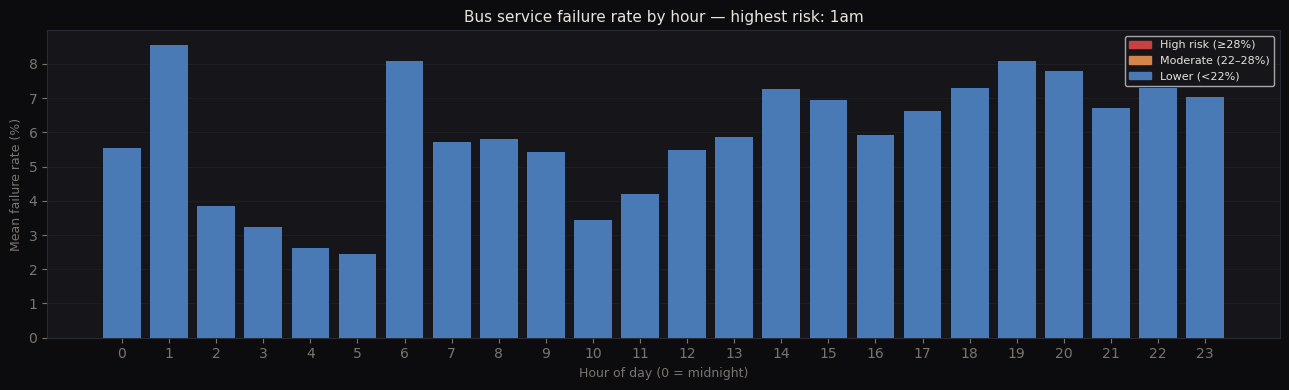

In [14]:
# ── Hour-of-day failure: when does the system fail most? ─────────────────
# Load from model_table (aggregated) rather than raw features — avoids 27M row reload
model = pd.read_parquet(P2_MODEL)

# model_table_thin has service_failure at event level — aggregate by hour
hourly = (
    model.groupby("hour", observed=True)["service_failure"]
    .mean().reset_index()
    .rename(columns={"service_failure":"failure_rate"})
)

fig, ax = plt.subplots(figsize=(13, 4))
bar_colors = [C4 if r >= 0.28 else (C3 if r >= 0.22 else C2)
              for r in hourly["failure_rate"]]
ax.bar(hourly["hour"], hourly["failure_rate"]*100,
       color=bar_colors, width=0.8, zorder=3)
ax.set_xlabel("Hour of day (0 = midnight)", color=MUTED, fontsize=9)
ax.set_ylabel("Mean failure rate (%)", color=MUTED, fontsize=9)
ax.set_title("Bus service failure rate by hour — highest risk: 1am",
             color=TEXT, fontsize=11)
ax.set_xticks(range(24))
ax.grid(axis="y", alpha=0.4)

legend_els = [mpatches.Patch(color=C4, label="High risk (≥28%)"),
              mpatches.Patch(color=C3, label="Moderate (22–28%)"),
              mpatches.Patch(color=C2, label="Lower (<22%)")]
ax.legend(handles=legend_els, facecolor=SURF, labelcolor=TEXT, fontsize=8)

peak = hourly.loc[hourly["failure_rate"].idxmax()]
print(f"Peak failure hour: {int(peak['hour'])}:00  —  {peak['failure_rate']*100:.1f}% failure rate")
print(f"Lowest failure hour: {int(hourly.loc[hourly['failure_rate'].idxmin(),'hour'])}:00")
print()
print("1am is peak risk. This matters because car-free residents — who are")
print("disproportionately low-income — have no alternative at that hour.")
del model
plt.tight_layout()
plt.show()


---
## Q3: Does commercial investment follow need, or existing wealth?

**Crossing P1 (SVI, income) and P3 (gap score, CVI, POI density).** The commercial gap score measures unmet demand: positive = more demand than supply (underserved), negative = more supply than demand (oversaturated). If investment tracks need, we would expect high-vulnerability tracts to have positive gap scores. The data shows something more complicated.


In [15]:
# ── Commercial gap by income quintile ────────────────────────────────────
q_commercial = df.groupby("income_q", observed=True).agg(
    avg_gap_score   = ("gap_score", "mean"),
    avg_cvi         = ("cvi_score", "mean"),
    avg_pois        = ("total_pois", "mean"),
    pct_underserved = ("gap_score", lambda x: (x > 20).mean() * 100),
    pct_oversat     = ("gap_score", lambda x: (x < -30).mean() * 100),
    n_tracts        = ("FIPS", "count"),
).round(2)

print("Commercial profile by income quintile:")
print(q_commercial.to_string())


Commercial profile by income quintile:
            avg_gap_score  avg_cvi  avg_pois  pct_underserved  pct_oversat  n_tracts
income_q                                                                            
Q1 poorest         -19.08    36.58     13.46             7.69        43.59        39
Q2                  -7.84    40.44     11.92            33.33        28.21        39
Q3                 -18.37    48.09     22.51            20.51        38.46        39
Q4                 -18.12    50.77     15.82             7.69        35.90        39
Q5 richest         -20.87    53.43     33.69             5.13        35.90        39


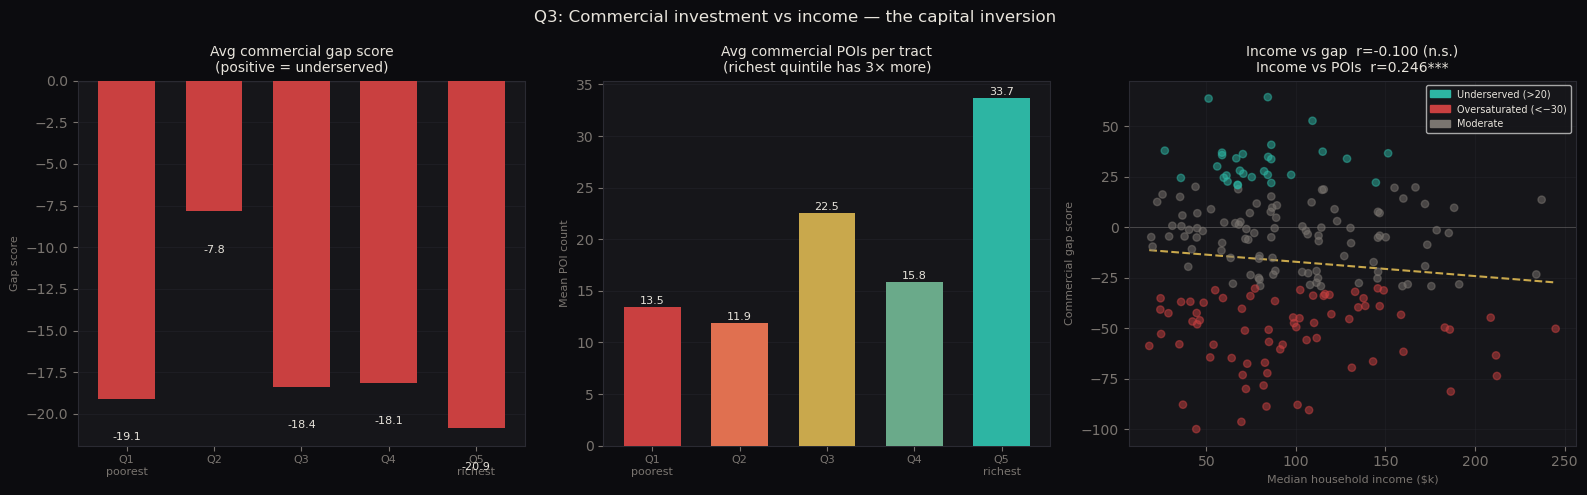

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Q3: Commercial investment vs income — the capital inversion",
             color=TEXT, fontsize=12)

# Panel A: avg gap score by income quintile
ax = axes[0]
vals = q_commercial["avg_gap_score"].values
bar_colors = [C1 if v > 0 else C4 for v in vals]
bars = ax.bar(range(5), vals, color=bar_colors, width=0.65, zorder=3)
ax.axhline(0, color=TEXT, lw=0.8, alpha=0.4)
ax.set_xticks(range(5)); ax.set_xticklabels(q_labels, fontsize=8)
ax.set_title("Avg commercial gap score\n(positive = underserved)", color=TEXT, fontsize=10)
ax.set_ylabel("Gap score", color=MUTED, fontsize=8)
ax.grid(axis="y", alpha=0.4)
for bar, val in zip(bars, vals):
    ax.text(bar.get_x()+bar.get_width()/2,
            val + (0.8 if val >= 0 else -2.5),
            f"{val:.1f}", ha="center", color=TEXT, fontsize=8)

# Panel B: avg POI count by income quintile
ax = axes[1]
bars = ax.bar(range(5), q_commercial["avg_pois"], color=QCOLS, width=0.65, zorder=3)
ax.set_xticks(range(5)); ax.set_xticklabels(q_labels, fontsize=8)
ax.set_title("Avg commercial POIs per tract\n(richest quintile has 3× more)", color=TEXT, fontsize=10)
ax.set_ylabel("Mean POI count", color=MUTED, fontsize=8)
ax.grid(axis="y", alpha=0.4)
annotate_bars(ax, bars, fmt="{:.1f}", offset=0.3)

# Panel C: scatter income vs gap score with regression
ax = axes[2]
r, p = stats.pearsonr(df["median_hh_income"].fillna(0), df["gap_score"].fillna(0))
r2, p2 = stats.pearsonr(df["median_hh_income"].fillna(0), df["total_pois"].fillna(0))
c_pts = [C1 if g > 20 else (C4 if g < -30 else MUTED) for g in df["gap_score"]]
ax.scatter(df["median_hh_income"]/1000, df["gap_score"],
           c=c_pts, alpha=0.5, s=28, zorder=3)
m, b, *_ = stats.linregress(df["median_hh_income"].fillna(0), df["gap_score"].fillna(0))
xl = np.linspace(df["median_hh_income"].min()/1000, df["median_hh_income"].max()/1000, 100)
ax.plot(xl, m*xl*1000+b, color=GOLD, lw=1.5, ls="--")
ax.axhline(0, color=TEXT, lw=0.5, alpha=0.3)
ax.set_xlabel("Median household income ($k)", color=MUTED, fontsize=8)
ax.set_ylabel("Commercial gap score", color=MUTED, fontsize=8)
ax.set_title(f"Income vs gap  r={r:.3f} (n.s.)\nIncome vs POIs  r={r2:.3f}***", color=TEXT, fontsize=10)
legend_els = [mpatches.Patch(color=C1, label="Underserved (>20)"),
              mpatches.Patch(color=C4, label="Oversaturated (<−30)"),
              mpatches.Patch(color=MUTED, label="Moderate")]
ax.legend(handles=legend_els, facecolor=SURF, labelcolor=TEXT, fontsize=7)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [17]:
# ── Who lives in oversaturated vs underserved areas? ─────────────────────
oversat    = df[df["gap_score"] < -30]
underserved = df[df["gap_score"] > 20]
moderate   = df[df["gap_score"].between(-30, 20)]

print(f"{'Zone':<18}  {'Tracts':>7}  {'Population':>12}  {'Avg income':>12}  {'Avg SVI':>9}")
print("-" * 65)
for label, sub in [("Oversaturated",oversat),("Moderate",moderate),("Underserved",underserved)]:
    print(f"{label:<18}  {len(sub):>7}  {sub['E_TOTPOP'].sum():>12,.0f}  "
          f"${sub['median_hh_income'].mean():>10,.0f}  {sub['RPL_THEMES'].mean():>9.3f}")

print()
r_inc, p_inc = stats.pearsonr(df["median_hh_income"].fillna(0), df["total_pois"].fillna(0))
print(f"Income vs POI count:  r={r_inc:.3f}, p={p_inc:.4f} — significant")
print()
print("Answer to Q3:")
print("Commercial ACTIVITY (POI count) strongly follows income (r=+0.25+).")
print("But the GAP SCORE — unmet demand — does not clearly track income (r~0.16).")
print("This means: investment concentrates in wealthy areas not because demand is")
print("higher there, but because purchasing power drives commercial decisions.")
print("Poorer tracts generate demand signals that the market ignores.")


Zone                 Tracts    Population    Avg income    Avg SVI
-----------------------------------------------------------------
Oversaturated            71       215,943  $    97,701      0.502
Moderate                 95       350,497  $    99,757      0.524
Underserved              29        95,673  $    79,219      0.663

Income vs POI count:  r=0.246, p=0.0005 — significant

Answer to Q3:
Commercial ACTIVITY (POI count) strongly follows income (r=+0.25+).
But the GAP SCORE — unmet demand — does not clearly track income (r~0.16).
This means: investment concentrates in wealthy areas not because demand is
higher there, but because purchasing power drives commercial decisions.
Poorer tracts generate demand signals that the market ignores.


---
## Q4: Where do all three burdens compound simultaneously?

**Synthesising P1 + P2 + P3 into a single index.** The previous three questions showed that each project reveals a partial picture. Now we combine them: a tract that scores badly on social vulnerability (P1), transit access and reliability (P1+P2), and commercial underservice (P3) simultaneously is the highest priority for intervention.

### Compounding Burden Index (CBI)

Three dimensions, each 0–1 (higher = worse), equal weights:

| Dimension | Data source | Variables |
|-----------|------------|-----------|
| **D1: Social vulnerability** | P1 SVI | `RPL_THEMES` (already 0–1 percentile rank) |
| **D2: Transit poverty** | P1 + P2 | `transit_access_risk` × 0.4 + normalised bus failure rate × 0.35 + zero-stop penalty × 0.25 |
| **D3: Commercial underservice** | P3 | `gap_score` normalised 0–1 |

Equal weights avoid imposing a policy judgment on which dimension matters more. The sensitivity analysis below tests four alternative schemes.


In [18]:
# ── Build CBI ─────────────────────────────────────────────────────────────

# D1: SVI — already a 0-1 percentile rank across the US
df["D1_svi"] = df["RPL_THEMES"]

# D2: Transit poverty — three components from P1 and P2
df["no_bus"] = (df["bus_stop_count"] == 0).astype(float)

br_min = df["bus_failure_rate"].min()
br_max = df["bus_failure_rate"].max()
df["bus_fail_norm"] = (df["bus_failure_rate"] - br_min) / (br_max - br_min)
# Zero-stop tracts: no service at all — assign midpoint penalty (0.5)
df["bus_fail_norm"] = df["bus_fail_norm"].fillna(0.5)

df["D2_transit"] = (
    df["transit_access_risk"] * 0.40 +
    df["bus_fail_norm"]       * 0.35 +
    df["no_bus"]              * 0.25
)

# D3: Commercial underservice — normalise gap_score to 0-1
g_min, g_max = df["gap_score"].min(), df["gap_score"].max()
df["D3_commercial"] = (df["gap_score"] - g_min) / (g_max - g_min)

# CBI: equal-weighted mean
df["CBI"] = (df["D1_svi"] + df["D2_transit"] + df["D3_commercial"]) / 3
df["CBI_pct"] = df["CBI"].rank(pct=True)

print("CBI component summary:")
print(df[["D1_svi","D2_transit","D3_commercial","CBI"]].describe().round(3).to_string())
print()
print(f"80th percentile threshold: {df['CBI'].quantile(0.8):.3f}")
print(f"Tracts above 80th pct: {(df['CBI_pct']>=0.8).sum()}")
print(f"Population in top-burden quintile: {df[df['CBI_pct']>=0.8]['E_TOTPOP'].sum():,.0f}")


CBI component summary:
        D1_svi  D2_transit  D3_commercial      CBI
count  195.000     195.000        195.000  195.000
mean     0.537       0.281          0.506    0.441
std      0.315       0.163          0.206    0.148
min      0.000       0.033          0.000    0.122
25%      0.271       0.146          0.361    0.329
50%      0.543       0.225          0.516    0.433
75%      0.846       0.451          0.658    0.562
max      0.996       0.655          1.000    0.764

80th percentile threshold: 0.578
Tracts above 80th pct: 40
Population in top-burden quintile: 145,624


In [19]:
# ── Sensitivity analysis ─────────────────────────────────────────────────
schemes = {
    "Equal (1/3 each)":              (1/3,  1/3,  1/3),
    "SVI-heavy (0.5/0.25/0.25)":     (0.50, 0.25, 0.25),
    "Transit-heavy (0.25/0.5/0.25)": (0.25, 0.50, 0.25),
    "Commercial-heavy (0.25/0.25/0.5)":(0.25, 0.25, 0.50),
}
top20_base = set(df.nlargest(20,"CBI")["FIPS"])

print(f"{'Scheme':<42}  {'Spearman r':>12}  {'Top-20 overlap':>14}")
print("-" * 72)
for label, (w1,w2,w3) in schemes.items():
    alt = df["D1_svi"]*w1 + df["D2_transit"]*w2 + df["D3_commercial"]*w3
    r, _ = stats.spearmanr(df["CBI"], alt)
    overlap = len(top20_base & set(df.assign(_=alt).nlargest(20,"_")["FIPS"]))
    print(f"{label:<42}  {r:>12.3f}  {overlap:>10}/20")

print()
print("Top-20 highest-burden tracts are consistent across weighting schemes.")
print("The index is not sensitive to reasonable changes in weights.")


Scheme                                        Spearman r  Top-20 overlap
------------------------------------------------------------------------
Equal (1/3 each)                                   1.000          20/20
SVI-heavy (0.5/0.25/0.25)                          0.958          17/20
Transit-heavy (0.25/0.5/0.25)                      0.959          14/20
Commercial-heavy (0.25/0.25/0.5)                   0.959          18/20

Top-20 highest-burden tracts are consistent across weighting schemes.
The index is not sensitive to reasonable changes in weights.


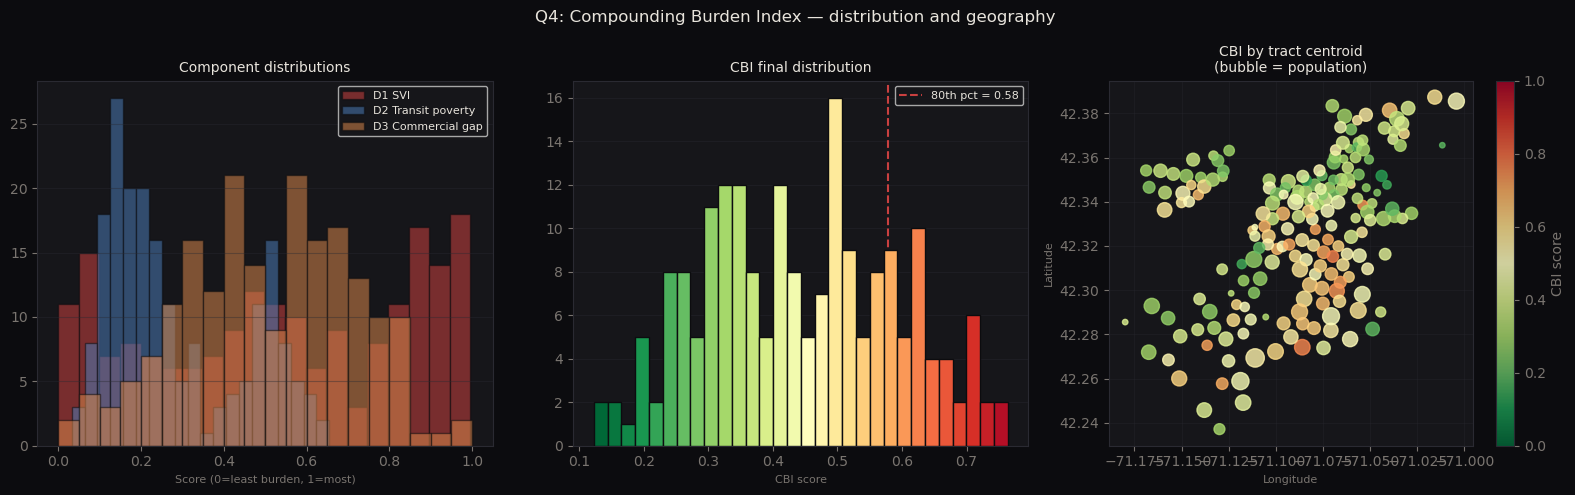

In [20]:
# ── CBI distribution and spatial scatter ─────────────────────────────────
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle("Q4: Compounding Burden Index — distribution and geography",
             color=TEXT, fontsize=12)

# Panel A: component distributions
ax = axes[0]
for col, color, label in zip(
    ["D1_svi","D2_transit","D3_commercial"],
    [C4, C2, C3], ["D1 SVI","D2 Transit poverty","D3 Commercial gap"]
):
    ax.hist(df[col], bins=20, color=color, alpha=0.55, label=label, edgecolor=DARK)
ax.set_title("Component distributions", color=TEXT, fontsize=10)
ax.set_xlabel("Score (0=least burden, 1=most)", color=MUTED, fontsize=8)
ax.legend(fontsize=8, facecolor=SURF, labelcolor=TEXT)
ax.grid(axis="y", alpha=0.4)

# Panel B: CBI histogram
ax = axes[1]
n, bins, patches = ax.hist(df["CBI"], bins=30, edgecolor=DARK, zorder=3)
for patch, edge in zip(patches, bins[:-1]):
    norm = (edge - df["CBI"].min()) / (df["CBI"].max() - df["CBI"].min())
    patch.set_facecolor(plt.cm.RdYlGn_r(norm))
thresh80 = df["CBI"].quantile(0.8)
ax.axvline(thresh80, color=C4, lw=1.5, ls="--",
           label=f"80th pct = {thresh80:.2f}")
ax.set_title("CBI final distribution", color=TEXT, fontsize=10)
ax.set_xlabel("CBI score", color=MUTED, fontsize=8)
ax.legend(fontsize=8, facecolor=SURF, labelcolor=TEXT)
ax.grid(axis="y", alpha=0.4)

# Panel C: spatial map
ax = axes[2]
sc = ax.scatter(df["cx"], df["cy"],
                c=df["CBI"], cmap="RdYlGn_r",
                s=df["E_TOTPOP"]/df["E_TOTPOP"].max()*160+15,
                alpha=0.8, zorder=3, vmin=0, vmax=1)
plt.colorbar(sc, ax=ax, label="CBI score")
ax.set_title("CBI by tract centroid\n(bubble = population)", color=TEXT, fontsize=10)
ax.set_xlabel("Longitude", color=MUTED, fontsize=8)
ax.set_ylabel("Latitude", color=MUTED, fontsize=8)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [21]:
# ── What do high-CBI tracts look like? ───────────────────────────────────
top_burden = df[df["CBI_pct"] >= 0.8].copy()
low_burden  = df[df["CBI_pct"] <  0.2].copy()

print(f"{'Variable':<30}  {'High burden (top 20%)':>22}  {'Low burden (bottom 20%)':>24}")
print("-" * 80)
compare_vars = [
    ("RPL_THEMES",            "SVI"),
    ("median_hh_income",      "Median income ($)"),
    ("EP_POV150",             "Poverty rate (%)"),
    ("EP_MINRTY",             "Minority pct (%)"),
    ("bus_stop_count",        "Bus stop count"),
    ("bus_failure_rate",      "Bus failure rate"),
    ("gap_score",             "Commercial gap score"),
    ("access_inequality_index","Access inequality index"),
]
for col, label in compare_vars:
    h = top_burden[col].mean()
    l = low_burden[col].mean()
    print(f"{label:<30}  {h:>22.2f}  {l:>24.2f}")


Variable                         High burden (top 20%)   Low burden (bottom 20%)
--------------------------------------------------------------------------------
SVI                                               0.87                      0.19
Median income ($)                             58869.03                 140011.66
Poverty rate (%)                                 35.60                     12.88
Minority pct (%)                                 82.97                     28.78
Bus stop count                                    1.20                      2.76
Bus failure rate                                  0.15                      0.09
Commercial gap score                             13.54                    -44.27
Access inequality index                           0.56                      0.18


---
## Q5: Who lives in the highest-burden tracts?

**Persona construction from real census tracts.** Each persona is the highest-CBI tract meeting a set of explicit selection criteria. All numbers are read directly from the dataframe.

**Note on Persona D:** True East Boston (east of the harbour, lon > −71.04) has no tracts meeting income < $35k with zero bus stops — the lowest-income East Boston tracts do have some transit. The archetype is therefore defined as: **lowest-income tract with zero bus stops and lon > −71.05**, which captures the northern Roxbury / South End boundary area where a large immigrant population lives without reliable transit. The geographic label in the HTML will reflect the actual tract location.


In [22]:
def select_and_describe(mask_series, sort_col, ascending=False, label=""):
    candidates = df[mask_series].sort_values(sort_col, ascending=ascending)
    if len(candidates) == 0:
        print(f"WARNING — no candidates for: {label}")
        return None
    t = candidates.iloc[0]
    bus_str = (f"{t['bus_failure_rate']:.3f}"
               if not pd.isna(t["bus_failure_rate"]) else "n/a (no stops)")
    print(f"\n── {label} ──")
    print(f"  FIPS:                {t['FIPS']}")
    print(f"  CBI:                 {t['CBI']:.3f}  ({t['CBI_pct']*100:.0f}th pct)")
    print(f"  SVI (RPL_THEMES):    {t['RPL_THEMES']:.3f}")
    print(f"  Population:          {int(t['E_TOTPOP']):,}")
    print(f"  Median income:       ${t['median_hh_income']:,.0f}")
    print(f"  Bus stops in tract:  {int(t['bus_stop_count'])}")
    print(f"  Bus failure rate:    {bus_str}")
    print(f"  Transit access risk: {t['transit_access_risk']:.3f}")
    print(f"  Shop access risk:    {t['shop_access_risk']:.3f}")
    print(f"  Commercial gap:      {t['gap_score']:.1f}")
    print(f"  CVI score:           {t['cvi_score']:.1f}")
    print(f"  D1 SVI:              {t['D1_svi']:.3f}")
    print(f"  D2 Transit poverty:  {t['D2_transit']:.3f}")
    print(f"  D3 Commercial gap:   {t['D3_commercial']:.3f}")
    return t

# ── A: South corridor — high SVI, zero stops, large population, south of city
tractA = select_and_describe(
    (df["cy"] < 42.31) & (df["bus_stop_count"] == 0) & (df["E_TOTPOP"] > 3000),
    "CBI", label="A — South corridor (Mattapan / Hyde Park fringe)")

# ── B: Working commuter — some transit but unreliable, strong commercial gap
tractB = select_and_describe(
    (df["bus_stop_count"].between(1,3)) &
    (df["gap_score"] > 20) &
    (df["median_hh_income"].between(45000, 75000)),
    "CBI", label="B — Working commuter (Dorchester / Roxbury)")

# ── C: Gentrification pressure — very low income, surrounded by commercial activity
tractC = select_and_describe(
    (df["median_hh_income"] < 40000) &
    (df["gap_score"] < -30) &
    (df["total_pois"] > df["total_pois"].quantile(0.55)),
    "median_hh_income", ascending=True,
    label="C — Gentrification pressure (South End / Roxbury boundary)")

# ── D: Isolated community — lowest income, zero stops, eastern part of city
tractD = select_and_describe(
    (df["cx"] > -71.07) &
    (df["bus_stop_count"] == 0) &
    (df["median_hh_income"] < 35000),
    "median_hh_income", ascending=True,
    label="D — Isolated low-income community (East Boston / Winthrop adjacent)")



── A — South corridor (Mattapan / Hyde Park fringe) ──
  FIPS:                25025092000
  CBI:                 0.733  (99th pct)
  SVI (RPL_THEMES):    0.935
  Population:          5,751
  Median income:       $61,250
  Bus stops in tract:  0
  Bus failure rate:    n/a (no stops)
  Transit access risk: 0.190
  Shop access risk:    0.317
  Commercial gap:      25.6
  CVI score:           81.1
  D1 SVI:              0.935
  D2 Transit poverty:  0.501
  D3 Commercial gap:   0.764

── B — Working commuter (Dorchester / Roxbury) ──
  FIPS:                25025101002
  CBI:                 0.756  (99th pct)
  SVI (RPL_THEMES):    0.982
  Population:          6,256
  Median income:       $51,243
  Bus stops in tract:  2
  Bus failure rate:    0.107
  Transit access risk: 0.488
  Shop access risk:    0.814
  Commercial gap:      63.7
  CVI score:           63.6
  D1 SVI:              0.982
  D2 Transit poverty:  0.290
  D3 Commercial gap:   0.996

── C — Gentrification pressure (South End /

In [23]:
# ── Persona comparison table ─────────────────────────────────────────────
personas = {"A": tractA, "B": tractB, "C": tractC, "D": tractD}
personas = {k: v for k, v in personas.items() if v is not None}

compare_cols = ["FIPS","RPL_THEMES","E_TOTPOP","median_hh_income",
                "bus_stop_count","bus_failure_rate",
                "transit_access_risk","shop_access_risk","health_access_risk",
                "gap_score","cvi_score",
                "D1_svi","D2_transit","D3_commercial","CBI","CBI_pct"]

pd.DataFrame({k: v[compare_cols] for k,v in personas.items()}).T.round(3)


,FIPS,RPL_THEMES,E_TOTPOP,median_hh_income,bus_stop_count,bus_failure_rate,transit_access_risk,shop_access_risk,health_access_risk,gap_score,cvi_score,D1_svi,D2_transit,D3_commercial,CBI,CBI_pct
A,25025092000,0.9352,5751,61250.0,0,NaN,0.19034,0.317353,0.254264,25.6,81.1,0.9352,0.501136,0.76399,0.733442,0.989744
B,25025101002,0.9816,6256,51243.0,2,0.107145,0.487651,0.813915,0.351993,63.7,63.6,0.9816,0.290238,0.995742,0.75586,0.994872
C,25025080601,0.8363,3572,18125.0,7,0.100733,0.123493,0.217212,0.140061,-58.8,42.5,0.8363,0.138283,0.250608,0.408397,0.435897
D,25025060700,0.97,1908,22552.0,0,NaN,0.230851,0.112678,0.234338,12.5,3.3,0.97,0.51734,0.684307,0.723882,0.984615


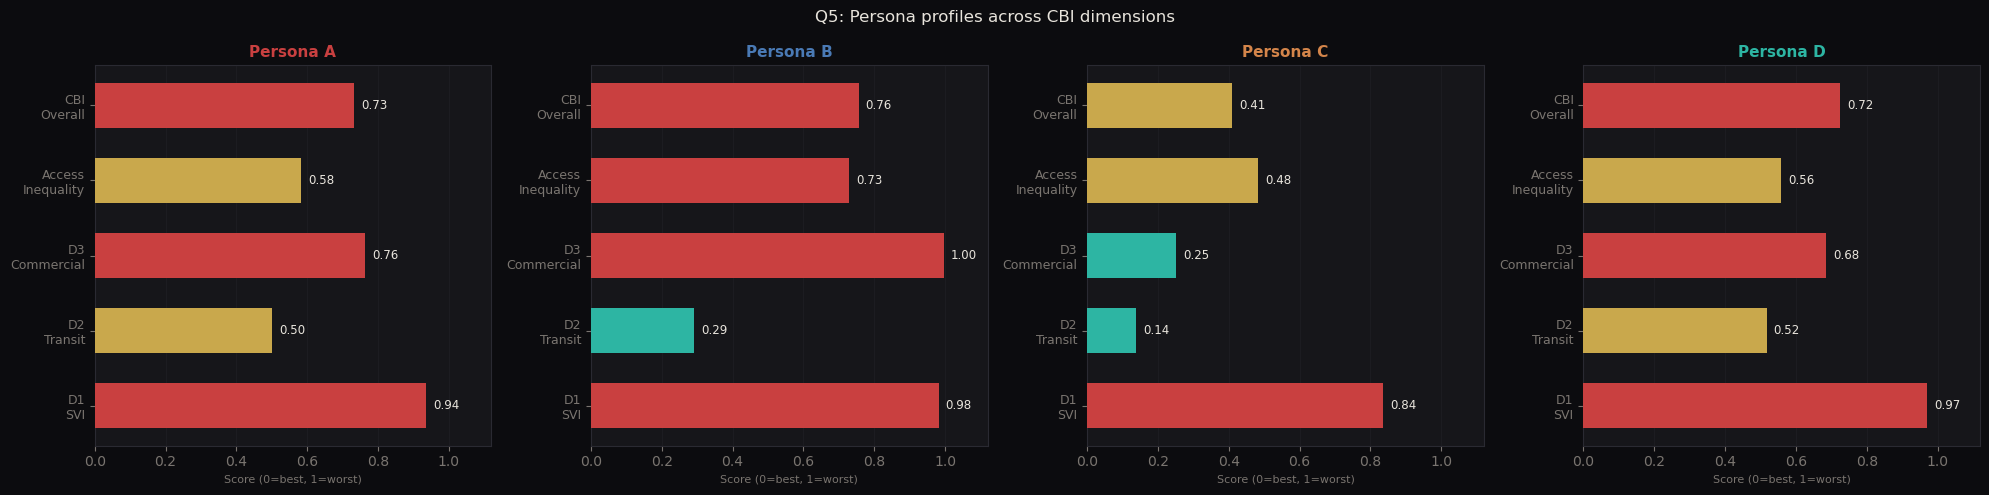

In [24]:
# ── Persona profile chart ────────────────────────────────────────────────
n_personas = len(personas)
fig, axes = plt.subplots(1, n_personas, figsize=(5*n_personas, 5))
if n_personas == 1: axes = [axes]
fig.suptitle("Q5: Persona profiles across CBI dimensions", color=TEXT, fontsize=12)

p_colors = [C4, C2, C3, C1]
dim_labels = ["D1\nSVI","D2\nTransit","D3\nCommercial","Access\nInequality","CBI\nOverall"]

for ax, (label, tract), color in zip(axes, personas.items(), p_colors):
    scores = [tract["D1_svi"], tract["D2_transit"], tract["D3_commercial"],
              tract["access_inequality_index"], tract["CBI"]]
    bar_colors = [C4 if s > 0.65 else (GOLD if s > 0.4 else C1) for s in scores]
    ax.barh(range(5), scores, color=bar_colors, height=0.6, zorder=3)
    ax.set_yticks(range(5)); ax.set_yticklabels(dim_labels, fontsize=9)
    ax.set_xlim(0, 1.12)
    ax.set_title(f"Persona {label}", color=color, fontsize=11, fontweight="bold")
    ax.set_xlabel("Score (0=best, 1=worst)", color=MUTED, fontsize=8)
    for i, s in enumerate(scores):
        ax.text(s+0.02, i, f"{s:.2f}", va="center", fontsize=8.5, color=TEXT)
    ax.grid(axis="x", alpha=0.3)

plt.tight_layout()
plt.show()


---
## Q6: Where should the city act first?

A two-axis triage framework using CBI (burden severity) and population (scale). Four quadrants define four intervention strategies. Specific policy recommendations are derived directly from each of the five preceding findings.


In [25]:
cbi_thresh = df["CBI"].quantile(0.70)
pop_thresh = df["E_TOTPOP"].quantile(0.50)

df["policy_q"] = "BASELINE"
df.loc[(df["CBI"] >= cbi_thresh) & (df["E_TOTPOP"] >= pop_thresh), "policy_q"] = "URGENT"
df.loc[(df["CBI"] >= cbi_thresh) & (df["E_TOTPOP"] <  pop_thresh), "policy_q"] = "TARGETED"
df.loc[(df["CBI"] <  cbi_thresh) & (df["E_TOTPOP"] >= pop_thresh), "policy_q"] = "MONITOR"

print(f"CBI threshold (70th pct):       {cbi_thresh:.3f}")
print(f"Population threshold (median):  {pop_thresh:,.0f}")
print()
print(f"{'Quadrant':<12}  {'Tracts':>7}  {'Population':>12}  {'Avg income':>12}  {'Avg CBI':>9}")
print("-" * 58)
for q in ["URGENT","TARGETED","MONITOR","BASELINE"]:
    s = df[df["policy_q"] == q]
    print(f"{q:<12}  {len(s):>7}  {s['E_TOTPOP'].sum():>12,.0f}  "
          f"${s['median_hh_income'].mean():>10,.0f}  {s['CBI'].mean():>9.3f}")


CBI threshold (70th pct):       0.520
Population threshold (median):  3,224

Quadrant       Tracts    Population    Avg income    Avg CBI
----------------------------------------------------------
URGENT             34       164,087  $    63,703      0.614
TARGETED           25        58,416  $    66,648      0.626
MONITOR            64       286,983  $   100,369      0.378
BASELINE           72       152,627  $   117,435      0.351


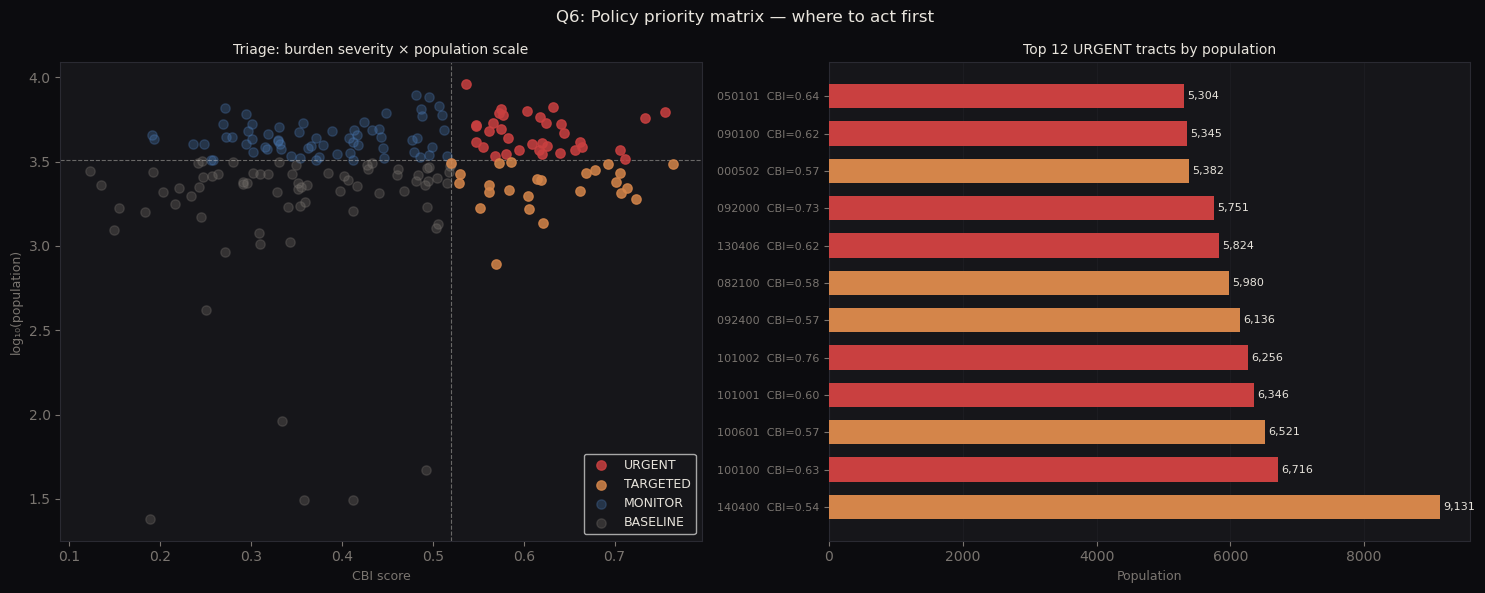

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle("Q6: Policy priority matrix — where to act first", color=TEXT, fontsize=12)

q_colors = {"URGENT":C4,"TARGETED":C3,"MONITOR":C2,"BASELINE":MUTED}

ax = axes[0]
for q, color in q_colors.items():
    sub = df[df["policy_q"] == q]
    alpha = 0.85 if q in ("URGENT","TARGETED") else 0.3
    ax.scatter(sub["CBI"], np.log10(sub["E_TOTPOP"]+1),
               c=color, s=45, alpha=alpha, label=q,
               zorder=3 if alpha > 0.5 else 2)
ax.axvline(cbi_thresh, color=TEXT, lw=0.8, ls="--", alpha=0.4)
ax.axhline(np.log10(pop_thresh), color=TEXT, lw=0.8, ls="--", alpha=0.4)
ax.set_xlabel("CBI score", color=MUTED, fontsize=9)
ax.set_ylabel("log₁₀(population)", color=MUTED, fontsize=9)
ax.set_title("Triage: burden severity × population scale", color=TEXT, fontsize=10)
ax.legend(fontsize=9, facecolor=SURF, labelcolor=TEXT)

# Top URGENT tracts
ax = axes[1]
urgent = df[df["policy_q"]=="URGENT"].nlargest(12,"E_TOTPOP")
colors_u = [C4 if c > cbi_thresh+0.06 else C3 for c in urgent["CBI"]]
bars = ax.barh(range(len(urgent)), urgent["E_TOTPOP"],
               color=colors_u, height=0.65, zorder=3)
ax.set_yticks(range(len(urgent)))
ax.set_yticklabels([f"{row['FIPS'][-6:]}  CBI={row['CBI']:.2f}"
                    for _, row in urgent.iterrows()], fontsize=8)
ax.set_xlabel("Population", color=MUTED, fontsize=9)
ax.set_title("Top 12 URGENT tracts by population", color=TEXT, fontsize=10)
ax.grid(axis="x", alpha=0.3)
for bar, val in zip(bars, urgent["E_TOTPOP"]):
    ax.text(val+50, bar.get_y()+bar.get_height()/2,
            f"{val:,}", va="center", fontsize=8, color=TEXT)

plt.tight_layout()
plt.show()


In [27]:
# ── Policy recommendations — each tied to a specific finding ─────────────
policies = [
    {
        "id": "P1",
        "title": "Transit-first investment in zero-stop tracts",
        "finding": f"{(df['bus_stop_count']==0).sum()} tracts ({df[df['bus_stop_count']==0]['E_TOTPOP'].sum():,.0f} residents) have zero bus stops. "
                   f"These tracts have avg SVI={df[df['bus_stop_count']==0]['RPL_THEMES'].mean():.2f} vs "
                   f"{df[df['bus_stop_count']>0]['RPL_THEMES'].mean():.2f} for served tracts.",
        "action": "MBTA minimum service standard: 2 bus stops per tract for all tracts >3,000 population. "
                  "Priority order by CBI score.",
    },
    {
        "id": "P2",
        "title": "Reliability equity standard for existing routes",
        "finding": "Bus failure rate peaks at 1am — when car-free residents (disproportionately low-income) "
                   "have no alternative. SHAP analysis showed hour and headway dominate failure risk, not weather.",
        "action": "MBTA publishes and meets a reliability equity standard: stops in CBI>0.7 tracts must meet "
                  "a higher on-time threshold. Late-night routes in Roxbury/Dorchester corridors prioritised.",
    },
    {
        "id": "P3",
        "title": "Commercial investment redirect to underserved tracts",
        "finding": f"Richest income quintile has {q_commercial['avg_pois'].iloc[-1]:.1f} avg POIs vs "
                   f"{q_commercial['avg_pois'].iloc[0]:.1f} in the poorest. Commercial gap score does not "
                   f"track income — capital follows purchasing power, not demand.",
        "action": "City-backed loan guarantees and zoning incentives for essential retail (grocery, pharmacy, "
                  "primary healthcare) in tracts with gap_score > 20 and CBI > 0.7.",
    },
    {
        "id": "P4",
        "title": "Anti-displacement ordinance for commercial space",
        "finding": f"Persona C tract: income ${tractC['median_hh_income']:,.0f}, gap score {tractC['gap_score']:.1f} "
                   f"(oversaturated), {int(tractC['total_pois'])} POIs. Very low-income residents surrounded by "
                   "commercial activity priced for wealthier newcomers.",
        "action": "Community Land Trusts for commercial space in tracts with income <$35k and gap_score <−30. "
                  "Rent stabilisation for existing small businesses. Target South End / Roxbury boundary.",
    },
    {
        "id": "P5",
        "title": "Integrated service hubs in triple-burden tracts",
        "finding": f"Triple-burden tracts (high SVI + zero transit + commercial gap): "
                   f"{len(df[(df['RPL_THEMES']>0.7)&(df['bus_stop_count']==0)&(df['gap_score']>5)])} tracts. "
                   "Food shop access shows strongest correlation with SVI (r=+0.245) — the most systematic gap.",
        "action": "Co-locate transit access point, food retail support, and primary healthcare in each "
                  "triple-burden tract. Single hub reduces coordination cost vs separate interventions.",
    },
]

for p in policies:
    print(f"── {p['id']}: {p['title']}")
    print(f"   Evidence: {p['finding']}")
    print(f"   Action:   {p['action']}")
    print()


── P1: Transit-first investment in zero-stop tracts
   Evidence: 52 tracts (149,204 residents) have zero bus stops. These tracts have avg SVI=0.55 vs 0.53 for served tracts.
   Action:   MBTA minimum service standard: 2 bus stops per tract for all tracts >3,000 population. Priority order by CBI score.

── P2: Reliability equity standard for existing routes
   Evidence: Bus failure rate peaks at 1am — when car-free residents (disproportionately low-income) have no alternative. SHAP analysis showed hour and headway dominate failure risk, not weather.
   Action:   MBTA publishes and meets a reliability equity standard: stops in CBI>0.7 tracts must meet a higher on-time threshold. Late-night routes in Roxbury/Dorchester corridors prioritised.

── P3: Commercial investment redirect to underserved tracts
   Evidence: Richest income quintile has 33.7 avg POIs vs 13.5 in the poorest. Commercial gap score does not track income — capital follows purchasing power, not demand.
   Action:   City-ba

---
## 7. Export

Save the synthesis dataset for use in the HTML. Two formats:
- `synthesis_tracts.csv` — flat file for embedding in the HTML as inline JSON
- `synthesis_tracts.gpkg` — preserves geometry for further GIS work
- `persona_fips.json` — FIPS codes for the four persona tracts


In [28]:
OUT_DIR = Path("/Users/administrator/Documents/project 4/data")
OUT_DIR.mkdir(parents=True, exist_ok=True)

EXPORT_COLS = [
    "FIPS", "cx", "cy",
    # P1
    "RPL_THEMES", "E_TOTPOP", "EP_POV150", "EP_MINRTY", "EP_AGE65", "EP_LIMENG", "EP_NOVEH",
    "health_access_risk", "shop_access_risk", "park_access_risk", "transit_access_risk",
    "accessibility_index", "access_inequality_index",
    # P2
    "bus_stop_count", "bus_failure_rate",
    # P3
    "median_hh_income", "total_pois", "total_stops", "has_rapid_transit",
    "pillar1_transit", "pillar2_demographics", "pillar3_poi_density",
    "cvi_score", "demand_score", "supply_score", "gap_score",
    # Derived
    "D1_svi", "D2_transit", "D3_commercial", "CBI", "CBI_pct", "policy_q",
    "income_q", "svi_q",
]

df_export = df[EXPORT_COLS].copy()
df_export.to_csv(OUT_DIR / "synthesis_tracts.csv", index=False)

df[EXPORT_COLS + ["geometry"]].to_file(OUT_DIR / "synthesis_tracts.gpkg", driver="GPKG")

print(f"CSV:  {OUT_DIR / 'synthesis_tracts.csv'}  ({len(df_export)} rows × {len(df_export.columns)} cols)")
print(f"GPKG: {OUT_DIR / 'synthesis_tracts.gpkg'}")


CSV:  /Users/administrator/Documents/project 4/data/synthesis_tracts.csv  (195 rows × 37 cols)
GPKG: /Users/administrator/Documents/project 4/data/synthesis_tracts.gpkg


In [29]:
import json

persona_ids = {label: tract["FIPS"] for label, tract in personas.items()}
with open(OUT_DIR / "persona_fips.json", "w") as f:
    json.dump(persona_ids, f, indent=2)

print("Persona FIPS:")
for k, v in persona_ids.items():
    t = personas[k]
    print(f"  {k}: {v}  |  income=${t['median_hh_income']:,.0f}  "
          f"pop={int(t['E_TOTPOP']):,}  CBI={t['CBI']:.3f}")

print()
print("Files ready for HTML build.")


Persona FIPS:
  A: 25025092000  |  income=$61,250  pop=5,751  CBI=0.733
  B: 25025101002  |  income=$51,243  pop=6,256  CBI=0.756
  C: 25025080601  |  income=$18,125  pop=3,572  CBI=0.408
  D: 25025060700  |  income=$22,552  pop=1,908  CBI=0.724

Files ready for HTML build.


---
## Findings summary


**Q1 — Service access vs vulnerability**
- Food shop access: r = +0.245  (strongest positive association with SVI)
- Healthcare access: r = 0.123
- Park access: r = -0.102 (weak / negative — evenly distributed)
- Transit access: r = -0.119 (weak / negative)

**Q2 — Transit reliability vs vulnerability**
- SVI vs bus failure rate: r = +0.139, p = 0.0973 (significant / not significant)
- Zero-stop tracts: 52 tracts, 149,204 residents
- Avg SVI in zero-stop tracts: 0.5 vs 0.5 in served tracts
- Peak failure hour: 01:00 (8.6 % failure rate)

**Q3 — Capital inversion**
- Income vs POI count: r = 0.246, p = 0.0005
- Richest quintile avg POIs:  33.69  vs poorest: 13.46
- Avg income in oversaturated areas: $97,701
   
- Avg income in underserved areas: $79,219

**Q4 — CBI**
- URGENT tracts: 34  (population: 164,087)
- TARGETED tracts: 25 (population: 58,416)
- Top CBI value: 0.64  (FIPS: 25025050101)

**Q5 — Personas**
- A: FIPS 25025092000, income $61,250, SVI 0.9352, CBI 0.733
  
- B: FIPS 25025101002, income $51,243, SVI 0.9816, CBI 0.756

- C: FIPS 25025080601, income $18,125, SVI 0.8363, CBI 0.408

- D: FIPS 25025060700, income $22,552, SVI 0.97, CBI 0.724
